<a href="https://colab.research.google.com/github/taegukang35/ML-study/blob/main/Guided_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad CAM test

In [17]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
model = VGG16(weights='imagenet')

In [18]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import load_model
tf.compat.v1.disable_eager_execution()

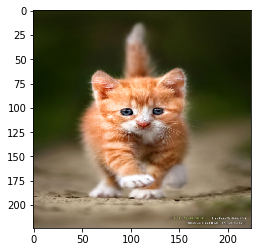

In [19]:
img_path = "/content/cats-gdragon-sunny-cat-41468892-533-800.jpg"
img = image.load_img(img_path,target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)
plt.imshow(img)

In [20]:
preds = model.predict(x)
print("Predicted: ",decode_predictions(preds,top=3)[0])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Predicted:  [('n02123159', 'tiger_cat', 0.44701844), ('n02119022', 'red_fox', 0.13196033), ('n02124075', 'Egyptian_cat', 0.11064851)]


In [22]:
np.argmax(preds[0])

282

In [23]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
# Grad-CAM 적용하는 과정. 
output = model.output[:,np.argmax(preds[0])]
last_conv_layer = model.layers[-6]
# block5_conv의 특성 맵 출력에 대한 클래스의 그래디언트 
grads = K.gradients(output,last_conv_layer.output)[0]
print(grads.shape)
# 특성 맵 채널별 그래디언트 평균값이 담딘 (512,) 크기의 벡터 
pooled_grads = K.mean(grads,axis=(0,1,2))
print(pooled_grads)
#샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구함. 
iterate = K.function([model.input],[pooled_grads,last_conv_layer.output[0]])
pooled_grads_value,conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:,:,i] *= pooled_grads_value[i]

(None, 14, 14, 512)
Tensor("Mean:0", shape=(512,), dtype=float32)


In [25]:
# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵
heatmap = np.mean(conv_layer_output_value,axis=-1)

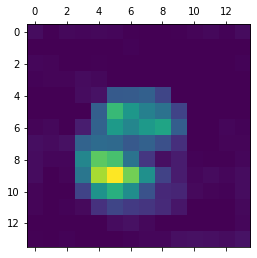

In [26]:
## ReLU를 씌원 음수를 0으로 만든다. 
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [27]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap) #heatmap을 RGB 포맷으로 변환
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET) #히트맵으로 변환
superimposed_img = heatmap*0.4 + img
cv2.imwrite('/content/elephant_cam.jpg',superimposed_img)

True

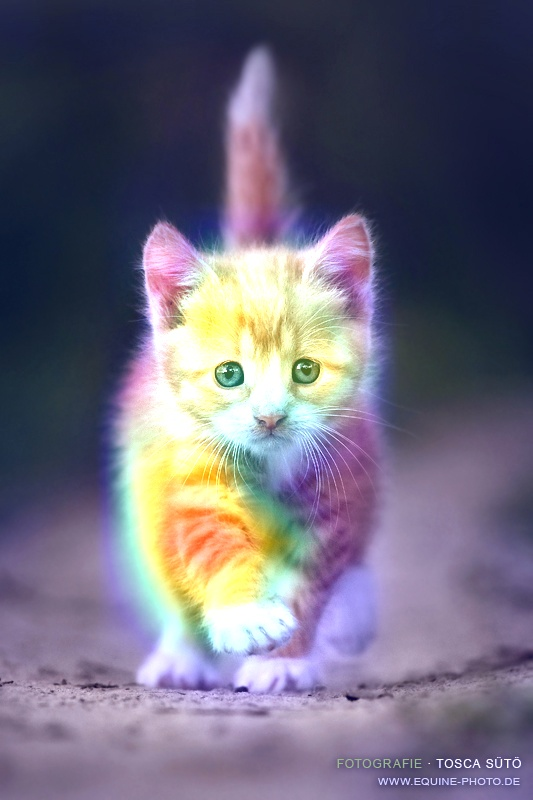

In [28]:
from IPython.display import Image
Image('/content/elephant_cam.jpg')

# Let's make it functional.

In [29]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input,decode_predictions
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import load_model
tf.compat.v1.disable_eager_execution()

In [30]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
model = VGG16(weights='imagenet')

In [31]:
def generate_grad_cam(img_tensor,model,class_index,activation_layer):
  inp = model.input
  y_c = model.output.op.inputs[0][0,class_index]
  A_k = model.get_layer(activation_layer).output
  
  ## 이미지 텐서 입력받아 해당 activation 레이어의 A_k와 
  ## 소프트맥스 함수 인풋의 A_k에 대한 gradient를 구한다. 
  get_output = K.function([inp],[A_k,K.gradients(y_c,A_k)[0],model.output])
  [conv_output,grad_val,model_output] = get_output([img_tensor])
  
  ## 배치 사이즈가 1이므로 배치 차원 없앰. 
  conv_output = conv_output[0]
  grad_val = grad_val[0]

  ## 구한 gradient를 픽셀 가로세로 평균내어 a^c_k를 계산 
  weights = np.mean(grad_val,axis = (0,1))

  ## 추출한 conv_output에 weight를 곱하고 합해 grad_cam을 얻는다. 
  grad_cam = np.zeros(dtype = np.float32, shape = conv_output.shape[0:2])
  for k,w in enumerate(weights):
    grad_cam += w*conv_output[:,:,k]
  grad_cam = cv2.resize(grad_cam,(224,224))
  
  ## ReLU를 씌워 음수를 0으로 만든다. 
  grad_cam = np.maximum(grad_cam,0)
  
  grad_cam = grad_cam/grad_cam.max()
  return grad_cam

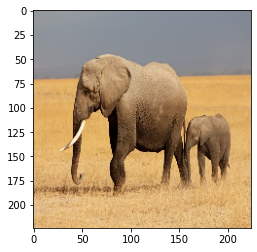

In [32]:
img_path = "/content/14956754019777.jpg"
img = image.load_img(img_path,target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)
plt.imshow(img)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


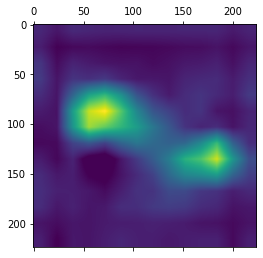

In [33]:
grad_cam = generate_grad_cam(x,model,np.argmax(model.predict(x)[0]),model.layers[-6].name)
plt.matshow(grad_cam)

In [34]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(grad_cam,(img.shape[1],img.shape[0]))
heatmap = np.uint8(255*heatmap) #heatmap을 RGB 포맷으로 변환
heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET) #히트맵으로 변환
superimposed_img = heatmap*0.4 + img
cv2.imwrite('/content/grad_cam.jpg',superimposed_img)

True

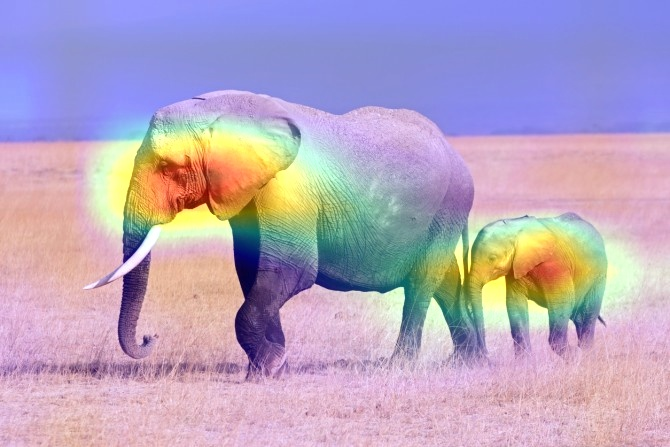

In [35]:
from IPython.display import Image
Image('/content/grad_cam.jpg')

#Guided Grad CAM

In [38]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K

import tensorflow as tf
from tensorflow.python.framework import ops

import numpy as np
import matplotlib.pyplot as plt
import cv2

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def load_image(path, target_size=(224, 224)):
    x = image.load_img(path, target_size=target_size)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def modify_backprop(model, name):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model
  
def guided_backpropagation(img_tensor, model, activation_layer):
    model_input = model.input
    layer_output = model.get_layer(activation_layer).output

    # one_output = layer_output[:, :, :, 256]
    max_output = K.max(layer_output, axis=3)

    get_output = K.function([model_input], [K.gradients(max_output, model_input)[0]])
    # get_output = K.function([model_input], [K.gradients(one_output, model_input)[0]])
    saliency = get_output([img_tensor])

    return saliency[0]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2401: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


predicted top1 class: 386
Predicted: [('n02504458', 'African_elephant', 0.7119862)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224)


(-0.5, 223.5, 223.5, -0.5)

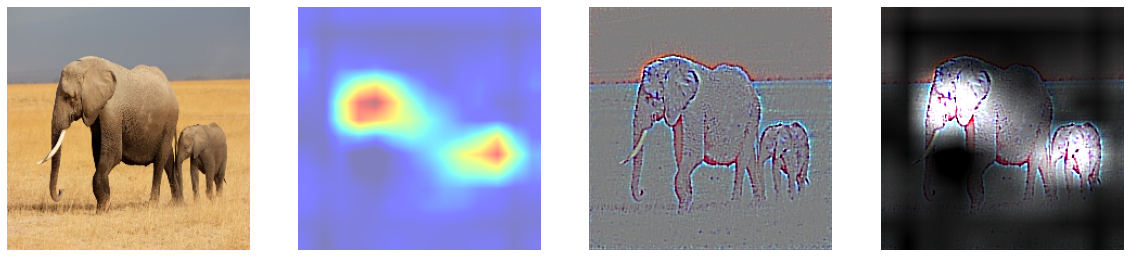

In [57]:
img_width = 224
img_height = 224

model = VGG16(weights='imagenet')
#print(model.summary())

img_path = '/content/14956754019777.jpg'
img = load_image(path=img_path, target_size=(img_width, img_height))

preds = model.predict(img)
predicted_class = preds.argmax(axis=1)[0]
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print("predicted top1 class:", predicted_class)
print('Predicted:', decode_predictions(preds, top=1)[0])
conv_name = 'block5_conv3'

grad_cam = generate_grad_cam(img, model, predicted_class, conv_name)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
gradient = guided_backpropagation(img, guided_model, conv_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (img_width, img_height))

fig = plt.figure(figsize=(20,10))
rows = 1
cols = 4
ax1 = fig.add_subplot(rows,cols,1)
grad_cam = cv2.resize(grad_cam, (img_width, img_height))
ax1.imshow(img)
ax1.axis('off')
ax2 = fig.add_subplot(rows,cols,2)
ax2.imshow(grad_cam, cmap="jet", alpha=.5)
ax2.axis('off')
ax3 = fig.add_subplot(rows,cols,3)
ax3.imshow(deprocess_image(gradient))
ax3.axis('off')
print(grad_cam.shape)
guided_gradcam = gradient[0]*(grad_cam[...,np.newaxis]*3)
ax4 = fig.add_subplot(rows,cols,4)
ax4.imshow(guided_gradcam)
ax4.axis('off')

array([2, 2, 2])